In [1]:
# 필요한 라이브러리를 로드합니다.
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

# 데이터 로더(data loader) 만들기

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
                        RandomSizedCrop(min_max_height=(300, 370),  # 50%의 확률로 RandomSizedCrop
                                        w2h_ratio=370/1242,
                                        height=224,
                                        width=224,
                                        p=0.5),
                        Resize(width=224, height=224)]) # 입력이미지를 224X224로 resize
    return Compose([Resize(width=224, height=224)])  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.

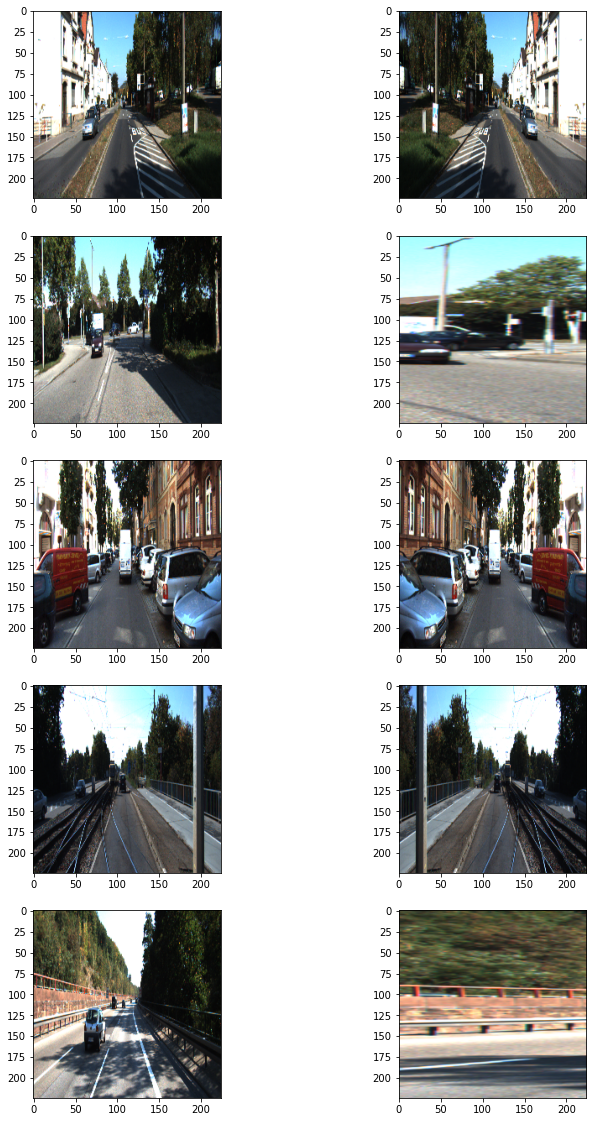

In [3]:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load 하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation 이 적용된 input image 이고
        # 출력은 semantic lebel 입니다.
        batch_data = self.data[index * self.batch_size: (index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8) * 1
            data = {"image": _input, "mask": _output}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에는 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation=augmentation, is_train=False)

![unet](https://d3s0tskafalll9.cloudfront.net/media/images/u-net_1kfpgqE.max-800x600.png)

# 모델 구조 만들기

In [6]:
def build_model(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    # Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model

# 모델 학습하기

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 25s 627ms/step - loss: 0.6936 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 7s 593ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 7s 596ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 7s 601ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 7s 598ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 7s 591ms/step - loss: 0.6903 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 6s 590ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 6s 586ms/step - loss: 0.6891 - val_loss: 0.6890
Epoch 9/100
11/11 [==============================] - 6s 584ms/step - loss: 0.6886 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 6s 579ms/step - loss: 0.6882 - val_l

# 모델 학습 결과 확인

In [8]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [9]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy() > 0.5).astype(np.uint8).squeeze(-1) * 255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

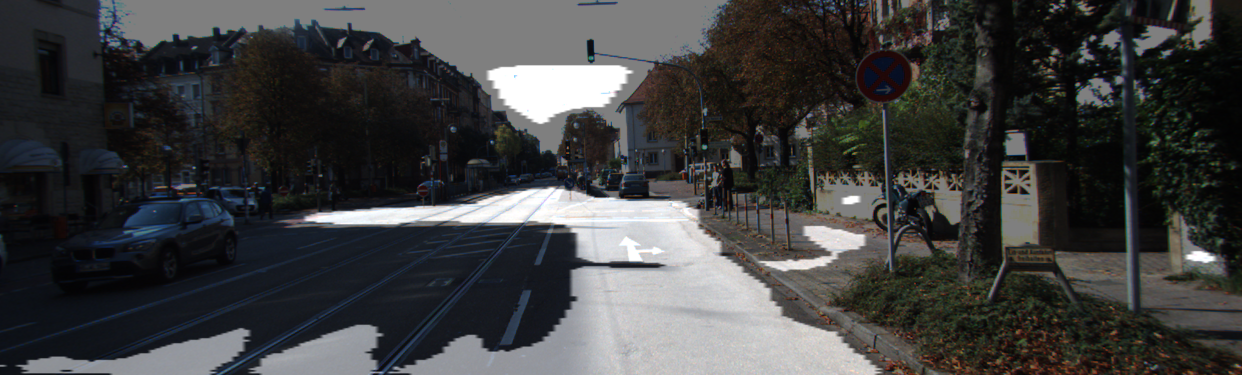

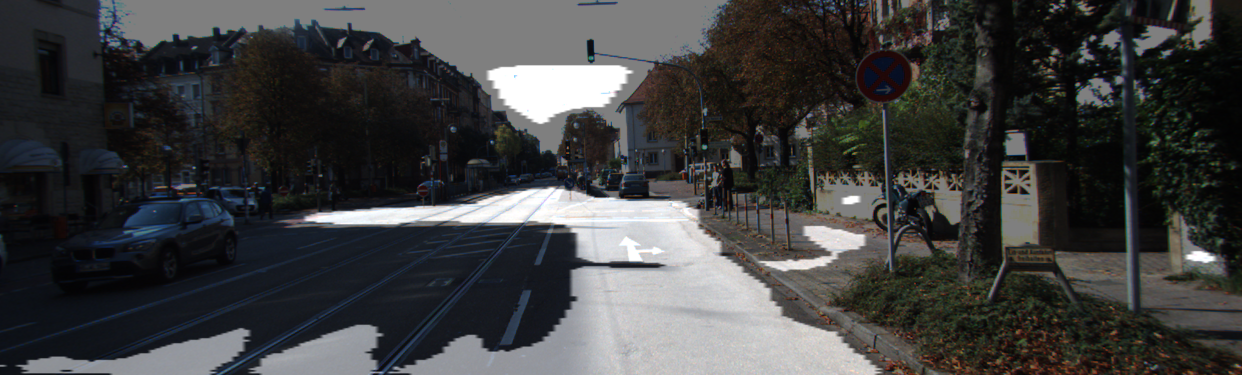

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

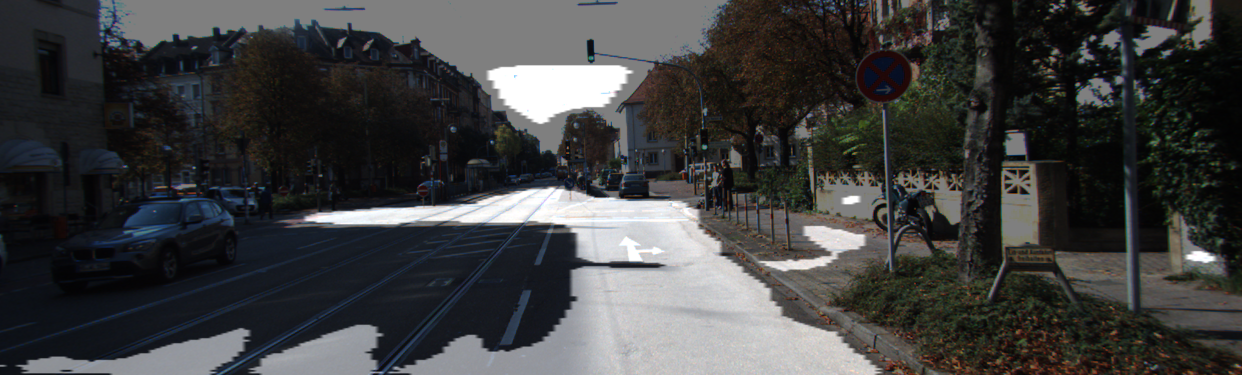

IoU : 0.419641


0.41964089410040306

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

---

# U-Net++ 모델의 구현

![unetpp](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

In [14]:
def conv2d_block(channel, x):
    x = Conv2D(channel, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(channel, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

In [15]:
def up_merge_block(channel, x, *args):
    up = Conv2DTranspose(channel, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x)
    merge = concatenate([*args, up], axis = 3)
    return merge

In [16]:
def build_model_pp(input_shape=(224, 224, 3)):
    model = None
    # U-Net channel = [64, 128, 256, 512, 1024]
    # U-Net++ channel = [70, 140, 280, 560, 1120]
    
    inputs = Input(input_shape)
    
    # _, 0
    conv2d0_0 = conv2d_block(70, inputs)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv2d0_0)
    
    conv2d1_0 = conv2d_block(140, pool0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2d1_0)
    
    conv2d2_0 = conv2d_block(280, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2d2_0)
    
    conv2d3_0 = conv2d_block(560, pool2)
    drop3 = Dropout(0.5)(conv2d3_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv2d4_0 = conv2d_block(1120, pool3)
    
    # _, 1
    up_merge0_1 = up_merge_block(70, conv2d1_0, conv2d0_0)
    conv2d0_1 = conv2d_block(70, up_merge0_1)
    
    up_merge1_1 = up_merge_block(140, conv2d2_0, conv2d1_0)
    conv2d1_1 = conv2d_block(140, up_merge1_1)
    
    up_merge2_1 = up_merge_block(280, conv2d3_0, conv2d2_0)
    conv2d2_1 = conv2d_block(280, up_merge2_1)
    
    up_merge3_1 = up_merge_block(560, conv2d4_0, conv2d3_0)
    conv2d3_1 = conv2d_block(560, up_merge3_1)
    
    
    # _, 2
    up_merge0_2 = up_merge_block(70, conv2d1_1, conv2d0_0, conv2d0_1)
    conv2d0_2 = conv2d_block(70, up_merge0_2)
    
    up_merge1_2 = up_merge_block(140, conv2d2_1, conv2d1_0, conv2d1_1)
    conv2d1_2 = conv2d_block(140, up_merge1_2)
    
    up_merge2_2 = up_merge_block(280, conv2d3_1, conv2d2_0, conv2d2_1)
    conv2d2_2 = conv2d_block(280, up_merge2_2)
    
    
    # _, 3
    up_merge0_3 = up_merge_block(70, conv2d1_2, conv2d0_0, conv2d0_1, conv2d0_2)
    conv2d0_3 = conv2d_block(70, up_merge0_3)
    
    up_merge1_3 = up_merge_block(140, conv2d2_2, conv2d1_0, conv2d1_1, conv2d1_2)
    conv2d1_3 = conv2d_block(140, up_merge1_3)
    
    # _, 4
    up_merge0_4 = up_merge_block(70, conv2d1_3, conv2d0_0, conv2d0_1, conv2d0_2, conv2d0_3)
    conv2d0_4 = conv2d_block(70, up_merge0_4)
    
    
    conv2d0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2d0_4)
    
    conv2d0_4 = Conv2D(1, 1, activation='sigmoid')(conv2d0_4)
    
    model = Model(inputs = inputs, outputs = conv2d0_4)
    
    return model

In [17]:
model_path_pp = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

model_pp = build_model_pp()
model_pp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model_pp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path_pp)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 66s 3s/step - loss: 0.6832 - val_loss: 0.6648
Epoch 2/100
11/11 [==============================] - 28s 3s/step - loss: 0.4296 - val_loss: 0.0399
Epoch 3/100
11/11 [==============================] - 27s 2s/step - loss: 0.0322 - val_loss: 0.0312
Epoch 4/100
11/11 [==============================] - 27s 2s/step - loss: 0.0405 - val_loss: 0.0351
Epoch 5/100
11/11 [==============================] - 27s 2s/step - loss: 0.0371 - val_loss: 0.0359
Epoch 6/100
11/11 [==============================] - 27s 2s/step - loss: 0.0351 - val_loss: 0.0384
Epoch 7/100
11/11 [==============================] - 27s 2s/step - loss: 0.0268 - val_loss: 0.0324
Epoch 8/100
11/11 [==============================] - 27s 2s/step - loss: 0.0294 - val_loss: 0.0366
Epoch 9/100
11/11 [==============================] - 27s 2s/step - loss: 0.0303 - val_loss: 0.0304
Epoch 10/100
11/11 [==============================] - 27s 2s/step - loss: 0.0245 - val_loss: 0.0283
Epoch 11/

# U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

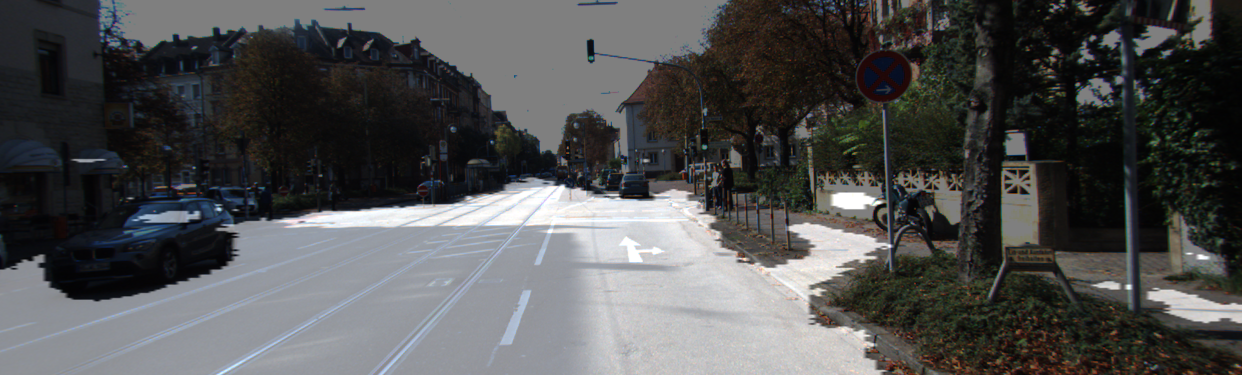

IoU : 0.891695


0.8916949274839454

In [21]:
# UNet++
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_pp, prediction_pp, target_pp = get_output(
     model_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target_pp, prediction_pp)

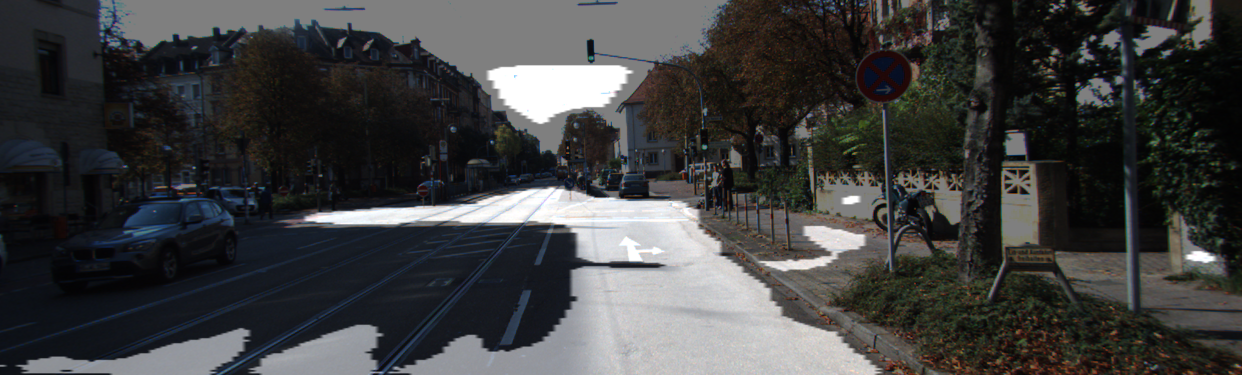

IoU : 0.419641


0.41964089410040306

In [22]:
# UNet
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output_pp, prediction_pp, target_pp = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target_pp, prediction_pp)

|Model|IoU Score|
|:----|-----|
|U-Net|0.419641|
|U-Net++|0.891695|

* U-Net 보다 U-Net++의 IoU Score 가 성능이 더 좋은것을 확일할 수 있습니다.

# 회고

* 본 과정에서는 U-Net과 U-Net++를 구현하고 도로 세그멘테이션 작업을 수행하고, 결과물의 차이와 IoU Score를 측정해서 비교해봅니다.  
* U-Net과 U-Net++의 도로 세그멘테이션 결과 사진만 보아도 상당한 영역에서 차이가 나며, IoU Score도 0.419 와 0.891 로 약 0.472 정도의 차이를 보여줍니다.  
* 위 결과처럼 세그멘테이션 영역이나 스코어 면에서 더 좋은 성능을 보여주지만, 결과 사진을 자세히보면 U-Net에서는 건물 그림자를 도로로 인식하지 못하였지만, U-Net++는 그림자로 가려진 도로까지 인식하였지만, 하늘과 자동차 일부, 담벼락 벽면, 심지어 인도의 상당부분까지 포함되는 큰 문제가 생겼습니다.
* 해당 문제를 해결하기위해 파라미터 조정이나 레이어구조를 조정해보아야 할 것 같습니다.